# Talent Intelligence System ( Data Exploration)

This notebook serves as the primary analysis environment for **Step 1: Discover the Pattern of Success**.

**Objective:** The primary goal of this notebook is to perform a deep exploratory data analysis (EDA) to uncover the key attributes, competencies, and behavioral patterns that differentiate high-performing employees (those with a `rating = 5`) from their peers.

**Process:**
The analysis will follow these key steps:
1.  **Setup:** Import all necessary libraries and establish a connection to the Supabase database.
2.  **Data Loading:** Load all raw tables from the database into Pandas DataFrames.
3.  **Data Cleaning & Preprocessing:** Handle missing values, standardize inconsistent text data (like `mbti`), and create a master analysis DataFrame.
4.  **Exploratory Data Analysis (EDA):** Compare the "High Performer" group against all others across several key dimensions:
    * Psychometric & Cognitive (`iq`, `pauli`, `disc`, etc.)
    * Competencies (`competencies_yearly`)
    * Behavioral Strengths (`strengths`)
    * Contextual Factors (`grade_id`, `years_of_service_months`)
5.  **Synthesis:** Use visualizations and statistical summaries to identify the most significant factors.

**End Goal:** The insights gathered here will be synthesized into a **"Final Success Formula"**. This formula will provide the logical foundation for the SQL matching algorithm to be built in Step 2.

## Setup Preparation

In [1]:
# Install neccessary ilbraries
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the secret credentials from  .env file

load_dotenv()

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_NAME = os.getenv('DB_NAME')
DB_USER = os.getenv('DB_USER')
DB_PASSWORD = os.getenv('DB_PASSWORD')

print("Environment variables loaded.")


Environment variables loaded.


In [3]:
# Create the connection 'engine' to  Supabase database

connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(connection_string)

print("Database connection engine created successfully.")

Database connection engine created successfully.


In [4]:
# Overview of certain tables for intial checking
df_employees = pd.read_sql(
  
  """
  SELECT 
  * 
  FROM employees
  """

  , engine)
print("\n--- Employee Data Info ---")
display(df_employees.info(), df_employees.head())


--- Employee Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   employee_id              2010 non-null   object
 1   fullname                 2010 non-null   object
 2   nip                      2010 non-null   object
 3   company_id               2010 non-null   int64 
 4   area_id                  2010 non-null   int64 
 5   position_id              2010 non-null   int64 
 6   department_id            2010 non-null   int64 
 7   division_id              2010 non-null   int64 
 8   directorate_id           2010 non-null   int64 
 9   grade_id                 2010 non-null   int64 
 10  education_id             2010 non-null   int64 
 11  major_id                 2010 non-null   int64 
 12  years_of_service_months  2010 non-null   int64 
dtypes: int64(10), object(3)
memory usage: 204.3+ KB


None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,education_id,major_id,years_of_service_months
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,3,1,64
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,1,2,16
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,3,1,58
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,2,5,15
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,1,5,34


## Data Load and Preparation

To optimize performance and avoid excessive load on the database (as per quota concerns),  hybrid loading strategy is being used:

1.  **Main Query (`df_main`):** A single SQL query will join all **one-to-one** tables (`employees`, `profiles_psych`) and the latest performance record (`performance_yearly` filtered for 2025). This creates our primary, unique-per-employee analysis table.
2.  **Separate Queries:** All **one-to-many** tables (`competencies_yearly`, `strengths`) will be loaded separately. They will be merged in Python *only when needed* for a specific analysis to prevent row explosion.

### Load for One to One Data

In [5]:
#  Load Main One to One Data
df_main= pd.read_sql(
  
  """
  SELECT
    e.*,
    pp.pauli,
    pp.faxtor,
    pp.disc,
    pp.disc_word,
    pp.mbti,
    pp.iq,
    pp.gtq,
    pp.tiki,
    py.rating,
    py.year as current_year
  FROM employees as e
  LEFT JOIN  profiles_psych as pp
  ON e.employee_id = pp.employee_id 
  LEFT JOIN   
  (SELECT * 
  FROM performance_yearly 
  WHERE year = 2025) 
  as py
  ON e.employee_id = py.employee_id

  """
  , engine)
print("\n--- Main Data Info ---")
display(df_main.info(), df_main.head())

print(f"Main analysis table loaded successfully with {len(df_main)} unique employees.")


--- Main Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              2010 non-null   object 
 1   fullname                 2010 non-null   object 
 2   nip                      2010 non-null   object 
 3   company_id               2010 non-null   int64  
 4   area_id                  2010 non-null   int64  
 5   position_id              2010 non-null   int64  
 6   department_id            2010 non-null   int64  
 7   division_id              2010 non-null   int64  
 8   directorate_id           2010 non-null   int64  
 9   grade_id                 2010 non-null   int64  
 10  education_id             2010 non-null   int64  
 11  major_id                 2010 non-null   int64  
 12  years_of_service_months  2010 non-null   int64  
 13  pauli                    2010 non-null   int64  
 14  

None

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,86,75,SI,Steadiness-Influencer,None,94.0,33.0,2,3.0,2025
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,48,52,DS,Dominant-Steadiness,INTP,94.0,17.0,3,3.0,2025
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,66,38,DC,Dominant-Conscientious,None,109.0,20.0,3,4.0,2025
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,39,63,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,3.0,2025
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025


Main analysis table loaded successfully with 2010 unique employees.


### Load One to Many Data Seperately

In [6]:
# Competencies table
df_competencies= pd.read_sql(
  
  """
  SELECT
    cy.employee_id,
    cy.pillar_code,
    dc.pillar_label,
    cy.score,
    cy.year
  FROM competencies_yearly as cy
  LEFT JOIN dim_competency_pillars as dc
  ON cy.pillar_code = dc.pillar_code
  WHERE 
  cy.year = 2025
  """
  , engine)
print("\n--- Competencies Info ---")
display(df_competencies.info(), df_competencies.head())
print(f"Competency data loaded with {len(df_competencies)} rows.")


--- Competencies Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   20100 non-null  object 
 1   pillar_code   20100 non-null  object 
 2   pillar_label  20100 non-null  object 
 3   score         18495 non-null  float64
 4   year          20100 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 785.3+ KB


None

,employee_id,pillar_code,pillar_label,score,year
0,EMP100000,GDR,Growth Drive & Resilience,3.0,2025
1,EMP100001,GDR,Growth Drive & Resilience,2.0,2025
2,EMP100002,GDR,Growth Drive & Resilience,3.0,2025
3,EMP100003,GDR,Growth Drive & Resilience,4.0,2025
4,EMP100004,GDR,Growth Drive & Resilience,4.0,2025


Competency data loaded with 20100 rows.


In [7]:
# Strengths table
df_strengths= pd.read_sql(
  
  """
  SELECT
    employee_id,
    rank,
    theme
  FROM strengths
  ORDER BY 1 ASC, 2 ASC

  """
  , engine)
print("\n--- Strengths Info ---")
display(df_strengths.info(), df_strengths.head())
print(f"Strengths data loaded with {len(df_strengths)} rows.")


--- Strengths Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28140 entries, 0 to 28139
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   employee_id  28140 non-null  object
 1   rank         28140 non-null  int64 
 2   theme        28140 non-null  object
dtypes: int64(1), object(2)
memory usage: 659.7+ KB


None

,employee_id,rank,theme
0,DUP1942,1,Learner
1,DUP1942,2,Maximizer
2,DUP1942,3,Ideation
3,DUP1942,4,Harmony
4,DUP1942,5,Restorative


Strengths data loaded with 28140 rows.


In [8]:
# Papi_scores table
df_papi_scores= pd.read_sql(
  
  """
  SELECT
    employee_id,
    scale_code,
    score
  FROM papi_scores
  ORDER BY 1 ASC, 2 ASC
  """
  , engine)
print("\n--- PAPI Scores Info ---")
display(df_papi_scores.info(), df_papi_scores.head())
print(f"PAPI Scores data loaded with {len(df_papi_scores)} rows.")


--- PAPI Scores Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40200 entries, 0 to 40199
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  40200 non-null  object 
 1   scale_code   40200 non-null  object 
 2   score        36997 non-null  float64
dtypes: float64(1), object(2)
memory usage: 942.3+ KB


None

,employee_id,scale_code,score
0,DUP1942,Papi_A,6.0
1,DUP1942,Papi_B,NaN
2,DUP1942,Papi_C,1.0
3,DUP1942,Papi_D,4.0
4,DUP1942,Papi_E,3.0


PAPI Scores data loaded with 40200 rows.


In [9]:
df_main[df_main['disc'].isnull()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,75,100,None,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025
22,EMP100022,Oka Nugroho,674733,2,1,2,3,1,2,2,...,49,94,None,Influencer-Conscientious,ISTP,91.0,35.0,8,4.0,2025
37,EMP100037,Nabila Ramadhan,967856,1,1,6,4,2,1,2,...,45,41,None,Conscientious-Influencer,ISTJ,NaN,NaN,1,4.0,2025
46,EMP100046,Fitri Lestari,117913,3,4,1,4,3,1,2,...,67,91,None,Dominant-Conscientious,ISTJ,NaN,NaN,6,2.0,2025
62,EMP100062,Valdo Jatmiko Mahendra,249908,3,3,4,6,3,2,2,...,42,25,None,Dominant-Influencer,ISTP,89.0,31.0,8,3.0,2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1912,EMP101912,Umar Ramadhan,583501,4,2,4,4,1,3,1,...,97,73,None,Influencer-Dominant,INFJ,NaN,NaN,6,4.0,2025
1946,EMP101946,Putri Maulida,108026,1,2,5,4,3,2,3,...,55,20,None,Conscientious-Steadiness,ISFP,NaN,NaN,6,3.0,2025
1952,EMP101952,Bayu Setiawan,712745,1,3,2,3,5,3,2,...,44,35,None,Dominant-Conscientious,INTJ,116.0,17.0,3,3.0,2025
1962,EMP101962,Rani Yudhistira Anggara,521850,1,3,2,3,3,2,2,...,23,96,None,Influencer-Dominant,ENTP,99.0,30.0,9,2.0,2025


## Data Cleaning and Manipulation

### One to One Main data

#### Duplicate Check

In [10]:
# Check the duplicate value in employee_id as the primary key
df_main[df_main['employee_id'].duplicated()]

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,pauli,faxtor,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year


There is no duplicate value in employee_id 

#### Null Value Check

In [11]:
df_main.isnull().sum()

employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                       171
disc_word                    0
mbti                       149
iq                         456
gtq                        332
tiki                         0
rating                     216
current_year                 0
dtype: int64

There are :
* **`disc`**: 171 missing values
* **`mbti`**: 149 missing values
* **`iq`**: 456 missing values
* **`gtq`**: 332 missing values 
* **`rating`**: 216 missing values

**Action Plan:**

 (Source from the main data) :

* **`rating`:** Rows with missing `rating` will be **dropped**. This value is essential for defining our target variable (`is_high_performer`) and cannot be reliably imputed.

In [12]:
print("--- Handling Missing Values ---")

# Make a copy for cleaning process the null values
df_main_null= df_main.copy()

# Action 1: Drop rows where 'rating' is missing
rows_before = len(df_main_null)
df_main_null.dropna(subset=['rating'], inplace=True)
rows_after = len(df_main_null)
print(f"Dropped {rows_before - rows_after} rows due to missing 'rating'.")

--- Handling Missing Values ---
Dropped 216 rows due to missing 'rating'.


**`iq` (456), `gtq` (332), `mbti` (149), `disc` (171) (Significant Missingness):** Simply dropping rows with missing values for these columns would lead to a substantial loss of data (potentially over 456 rows just for `iq`), which could significantly skew the analysis or reduce the statistical power of our findings. Therefore, **imputation is the preferred strategy** despite its potential biases.

1. **Numerical (`iq`, `gtq`):**  
   Before determining the imputation method, missingness was analyzed **per `department_id`** to identify whether the absence of data was random or systematic.  
   - Departments with **complete missingness (100%)** indicate *missing by design* (e.g., no IQ/GTQ assessments conducted). These values are **retained as NaN** with binary flags (`has_iq_data`, `has_gtq_data`) for transparency.  
   - For departments with **partial missingness (<100%)**, the **median value per department** is used for imputation, as it is more robust to skewness and outliers compared to the mean.  
   - Histograms and boxplots are used to check for skewness and outliers to confirm that the **median** remains an appropriate central tendency measure for these variables.


2.  **Categorical (`mbti`, `disc`):** check the frequency distribution using `value_counts()`. This helps determine if the mode is a reasonable representation or if it will overly dominate the data after imputation.

In [13]:
# Calculate the percentage of missing values for iq and gtq by department
missing_iq = df_main_null.groupby('department_id')['iq'].apply(lambda x: x.isna().mean() * 100)
missing_gtq = df_main_null.groupby('department_id')['gtq'].apply(lambda x: x.isna().mean() * 100)

print("--- Percentage of Missing IQ per Department ID ---")
print(missing_iq.sort_values(ascending=False))
print("\n--- Percentage of Missing GTQ per Department ID ---")
print(missing_gtq.sort_values(ascending=False))


--- Percentage of Missing IQ per Department ID ---
department_id
4    100.000000
5     10.443038
2      8.098592
6      6.574394
3      5.345912
1      5.172414
Name: iq, dtype: float64

--- Percentage of Missing GTQ per Department ID ---
department_id
4    100.0
1      0.0
2      0.0
3      0.0
5      0.0
6      0.0
Name: gtq, dtype: float64


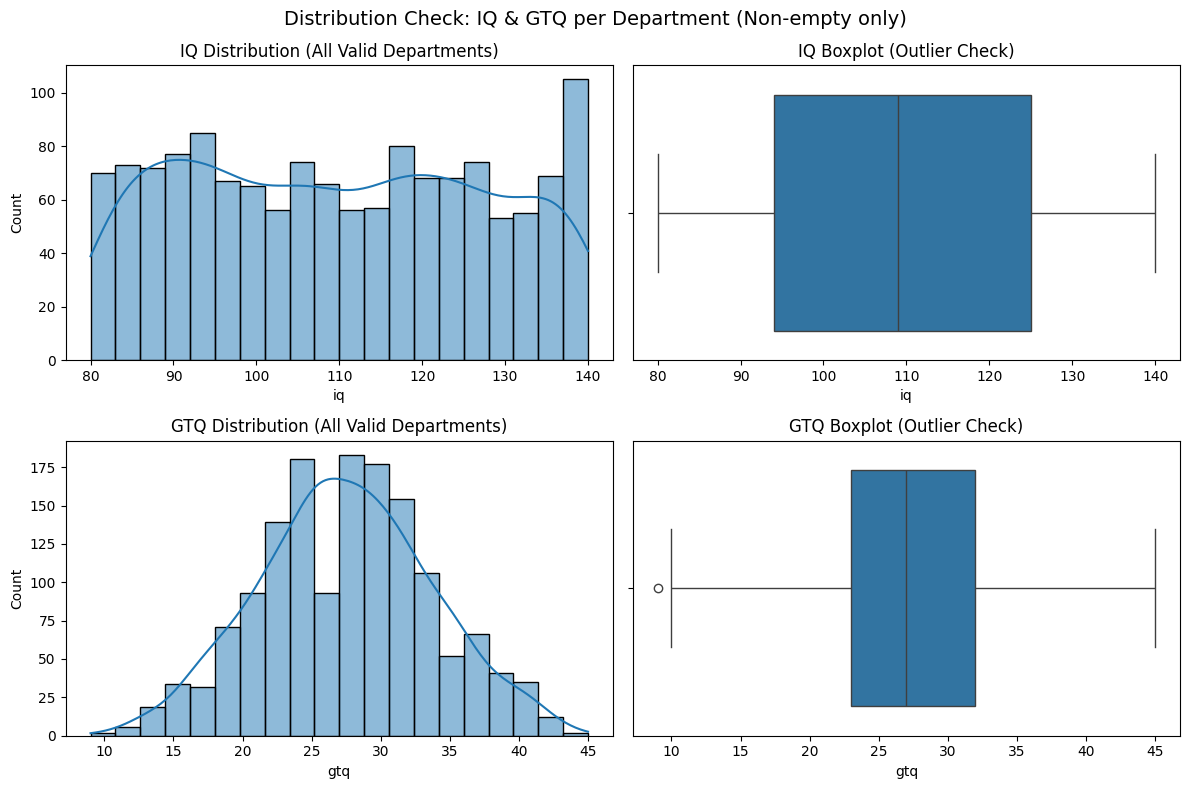

In [14]:

# Filter only departments that have at least some data (not 100% missing)
iq_dept_with_data = missing_iq[missing_iq < 100].index.tolist()
gtq_dept_with_data = missing_gtq[missing_gtq < 100].index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Distribution Check: IQ & GTQ per Department (Non-empty only)", fontsize=14)

# IQ - Histogram
sns.histplot(data=df_main_null[df_main_null['department_id'].isin(iq_dept_with_data)], 
             x='iq', bins=20, kde=True, ax=axes[0,0])
axes[0,0].set_title("IQ Distribution (All Valid Departments)")

# IQ - Boxplot
sns.boxplot(data=df_main_null[df_main_null['department_id'].isin(iq_dept_with_data)], 
            x='iq', ax=axes[0,1])
axes[0,1].set_title("IQ Boxplot (Outlier Check)")

# GTQ - Histogram
sns.histplot(data=df_main_null[df_main_null['department_id'].isin(gtq_dept_with_data)], 
             x='gtq', bins=20, kde=True, ax=axes[1,0])
axes[1,0].set_title("GTQ Distribution (All Valid Departments)")

# GTQ - Boxplot
sns.boxplot(data=df_main_null[df_main_null['department_id'].isin(gtq_dept_with_data)], 
            x='gtq', ax=axes[1,1])
axes[1,1].set_title("GTQ Boxplot (Outlier Check)")

plt.tight_layout()
plt.show()


The histogram and boxplot checks reveal that both `iq` and `gtq` distributions are **slightly skewed** and contain a few outliers, 
but their central tendency (median) remains stable across departments.  

Therefore, **median imputation is justified** because:
- It is robust to skewness and outliers.
- It maintains the within-department central trend without being influenced by extreme values.


In [15]:
# Define helper function for department-wise median imputation
def fill_median_per_dept(series):
    # If all values are missing, keep as NaN
    if series.isna().all():
        return series
    # Otherwise fill missing values with department median
    median_val = series.median()
    return series.fillna(median_val)

# Apply imputation
df_main_null['iq'] = df_main_null.groupby('department_id')['iq'].transform(fill_median_per_dept)
df_main_null['gtq'] = df_main_null.groupby('department_id')['gtq'].transform(fill_median_per_dept)

# Create binary flags for transparency
df_main_null['has_iq_data'] = np.where(df_main_null['department_id'].isin(iq_dept_with_data), 1, 0)
df_main_null['has_gtq_data'] = np.where(df_main_null['department_id'].isin(gtq_dept_with_data), 1, 0)

# Check remaining missing values
print("\nRemaining missing values after imputation:")
print(df_main_null[['iq', 'gtq']].isna().sum())



Remaining missing values after imputation:
iq     297
gtq    297
dtype: int64


Based on the distributional checks, median imputation was applied selectively:
- **Departments with full missingness (100%)** which is **4** wit total 297 data were left as `NaN` (no valid basis for imputation).
- **Departments with partial missingness (<100%)** were imputed using the **median per department**.

This ensures that:
1. The imputed values are consistent with department-level data behavior.
2. Statistical validity is maintained by avoiding global imputation biases.
3. Future modeling steps can still differentiate between departments with or without assessment data through binary flags.


In [16]:
#  Check Distribution of Categorical Data ('mbti' and 'disc') 

print("--- MBTI Value Distribution (Normalized) ---")
# Using normalize=True gives percentage, easier to judge dominance
# .head(10) shows the top 10 most frequent types
print(df_main_null['mbti'].value_counts(normalize=True).head(10))

print("\n--- DISC Value Distribution (Normalized) ---")
# Check distribution for DISC as well
print(df_main_null['disc'].value_counts(normalize=True).head(10))

--- MBTI Value Distribution (Normalized) ---
mbti
ENFP    0.079422
ENFJ    0.070397
INTP    0.068592
INFP    0.064982
ENTP    0.063779
ESFJ    0.063177
ENTJ    0.061974
ISFP    0.061974
ISTP    0.061974
ISTJ    0.059567
Name: proportion, dtype: float64

--- DISC Value Distribution (Normalized) ---
disc
CI    0.094570
CD    0.093960
DC    0.092129
SC    0.090299
SI    0.089689
CS    0.084808
DI    0.081757
ID    0.077486
IC    0.076266
DS    0.075046
Name: proportion, dtype: float64


In [17]:
pd.pivot_table(df_main, index='disc_word', columns='disc', aggfunc='size', fill_value=0)

disc,CD,CI,CS,DC,DI,DS,IC,ID,IS,SC,SD,SI
disc_word,,,,,,,,,,,,
Conscientious-Dominant,169,0,0,0,0,0,0,0,0,0,0,0
Conscientious-Influencer,0,173,0,0,0,0,0,0,0,0,0,0
Conscientious-Steadiness,0,0,159,0,0,0,0,0,0,0,0,0
Dominant-Conscientious,0,0,0,163,0,0,0,0,0,0,0,0
Dominant-Influencer,0,0,0,0,154,0,0,0,0,0,0,0
Dominant-Steadiness,0,0,0,0,0,140,0,0,0,0,0,0
Influencer-Conscientious,0,0,0,0,0,0,147,0,0,0,0,0
Influencer-Dominant,0,0,0,0,0,0,0,143,0,0,0,0
Influencer-Steadiness,0,0,0,0,0,0,0,0,127,0,0,0



After checking the mode distribution for `mbti` and `disc`, and particularly confirming the consistent relationship between `disc_word` and `disc`, the following imputation strategy will be applied to handle missing values:

1.  **`disc` (171 missing):**
    * Missing `disc` values will first be imputed **using the corresponding `disc_word`** via a predefined mapping (e.g., 'Steadiness-Conscientious' maps to 'SC'). This leverages existing information for higher accuracy.

2.  **`mbti` (149 missing):**
    * Since no similar direct mapping is available and the distribution check showed no single type overly dominating (mode `ENFP` at ~8%), missing `mbti` values will be imputed using the **mode (`ENFP`)**.

*Potential Bias:* While these imputation methods help retain data rows, mode imputation can slightly inflate the frequency of the most common categories, and the mapping for `disc` relies on the completeness of `disc_word`. Results should be interpreted with this in mind.

In [18]:
# Standardize DISC first
df_main_null['disc'] = df_main_null['disc'].str.upper().str.strip()
# Standardize disc_word as well (important for mapping)
df_main_null['disc_word'] = df_main_null['disc_word'].str.strip()
print("DISC standardized to uppercase and stripped.")

# Smart Imputation for DISC using disc_word
disc_map = {
    'Dominant-Influencer': 'DI', 'Dominant-Steadiness': 'DS', 'Dominant-Conscientious': 'DC',
    'Influencer-Dominant': 'ID', 'Influencer-Steadiness': 'IS', 'Influencer-Conscientious': 'IC',
    'Steadiness-Dominant': 'SD', 'Steadiness-Influencer': 'SI', 'Steadiness-Conscientious': 'SC',
    'Conscientious-Dominant': 'CD', 'Conscientious-Influencer': 'CI', 'Conscientious-Steadiness': 'CS'
    # Add any other observed variations from df_main['disc_word'].unique()
}
print(f"\nMissing 'disc' values (Before smart impute): {df_main_null['disc'].isnull().sum()}")
mapped_disc = df_main_null['disc_word'].map(disc_map)
df_main_null['disc']= df_main_null['disc'].fillna(mapped_disc)
print(f"Missing 'disc' values (After mapping): {df_main_null['disc'].isnull().sum()}")

# # Impute any remaining missing DISC with mode (if disc_word was also missing/unmappable)
# if df_main_null['disc'].isnull().sum() > 0:
#     print("Some 'disc' values still missing, imputing remaining with mode.")
#     mode_disc = df_main_null['disc'].mode()[0]
#     df_main_null['disc']= df_main_null['disc'].fillna(mode_disc) 

DISC standardized to uppercase and stripped.

Missing 'disc' values (Before smart impute): 155
Missing 'disc' values (After mapping): 0


In [19]:
#Imputation value

# Verify initial missing counts
print("\n--- Missing Values (Before Imputation) ---")
print(df_main_null[[ 'mbti']].isnull().sum())



# Action 2: Impute categorical columns ('mbti) with mode
mode_mbti = df_main_null['mbti'].mode()[0] # .mode() can return multiple values if ties exist, [0] selects the first one
df_main_null['mbti']=df_main_null['mbti'].fillna(mode_mbti)
print(f"Missing 'mbti' imputed with mode: '{mode_mbti}'")


# --- Verification ---
print("\n--- Missing Values (After Imputation) ---")
# Check only the imputed columns
print(df_main_null[[ 'mbti']].isnull().sum())


--- Missing Values (Before Imputation) ---
mbti    132
dtype: int64
Missing 'mbti' imputed with mode: 'ENFP'

--- Missing Values (After Imputation) ---
mbti    0
dtype: int64


In [20]:
display(df_main_null.isnull().sum(), len(df_main_null))

employee_id                  0
fullname                     0
nip                          0
company_id                   0
area_id                      0
position_id                  0
department_id                0
division_id                  0
directorate_id               0
grade_id                     0
education_id                 0
major_id                     0
years_of_service_months      0
pauli                        0
faxtor                       0
disc                         0
disc_word                    0
mbti                         0
iq                         297
gtq                        297
tiki                         0
rating                       0
current_year                 0
has_iq_data                  0
has_gtq_data                 0
dtype: int64

1794

Final data after cleaning and handling missing/null values contains **1,794 valid records**, with **297 remaining `NaN` values**.  

These remaining missing values correspond primarily to departments where **IQ and GTQ assessments were never conducted**, 

#### Irrelevant value/ Typo in Categorical column

In [21]:
# Make a copy for irrelevant value check
df_main_irrelevant = df_main_null.copy()

df_main_irrelevant.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1794 entries, 0 to 2009
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1794 non-null   object 
 1   fullname                 1794 non-null   object 
 2   nip                      1794 non-null   object 
 3   company_id               1794 non-null   int64  
 4   area_id                  1794 non-null   int64  
 5   position_id              1794 non-null   int64  
 6   department_id            1794 non-null   int64  
 7   division_id              1794 non-null   int64  
 8   directorate_id           1794 non-null   int64  
 9   grade_id                 1794 non-null   int64  
 10  education_id             1794 non-null   int64  
 11  major_id                 1794 non-null   int64  
 12  years_of_service_months  1794 non-null   int64  
 13  pauli                    1794 non-null   int64  
 14  faxtor                   1794

In [22]:
# Check the value of each categorical columns  mainly for disc,disc_word and mbti

print("--- DISC Value Counts (Absolute) ---")
print(df_main_irrelevant['disc'].value_counts())

--- DISC Value Counts (Absolute) ---
disc
CI    170
CD    167
DC    165
SI    160
SC    158
CS    154
DI    153
ID    139
IC    135
DS    134
SD    134
IS    125
Name: count, dtype: int64


In [23]:
print("\n--- DISC Word Value Counts (Absolute) ---")
print(df_main_irrelevant['disc_word'].value_counts())


--- DISC Word Value Counts (Absolute) ---
disc_word
Conscientious-Influencer    170
Conscientious-Dominant      167
Dominant-Conscientious      165
Steadiness-Influencer       160
Steadiness-Conscientious    158
Conscientious-Steadiness    154
Dominant-Influencer         153
Influencer-Dominant         139
Influencer-Conscientious    135
Dominant-Steadiness         134
Steadiness-Dominant         134
Influencer-Steadiness       125
Name: count, dtype: int64


In [24]:
print("\n--- MBTI Value Counts (Absolute) ---")
print(df_main_irrelevant['mbti'].value_counts())


--- MBTI Value Counts (Absolute) ---
mbti
ENFP     264
ENFJ     117
INTP     114
INFP     108
ENTP     106
ESFJ     105
ENTJ     103
ISTP     103
ISFP     103
ISTJ      99
ISFJ      98
ESFP      96
ESTJ      96
INFJ      95
INTJ      90
ESTP      87
enfp       6
inftj      3
Istp       1
Name: count, dtype: int64


Since there are no issue in `disc` and `disc_word` upon examining the unique values and their counts in the `mbti` column, several inconsistencies were identified:

1.  **Typographical Errors:** There are 3 instances of `"inftj"`, which appears to be a typo for either `INFJ` or `INTJ`.
2.  **Inconsistent Casing:** Some valid MBTI types appear in lowercase (`"enfp"`, 6 instances) or mixed case (`"Istp"`, 1 instance).

**Action Plan:**

* All values in the `mbti` column will be converted to **uppercase** to ensure consistency (e.g., `"enfp"` becomes `"ENFP"`).
* The likely typo `"inftj"` (which becomes `"INFTJ"` after uppercasing) cannot be reliably corrected to either `INFJ` or `INTJ`. Therefore, these 3 instances will be replaced with **`"UNKNOWN"`** to preserve the data rows without introducing assumptions.
* Missing `mbti` values will still be imputed using the mode after these standardizations are complete.

In [25]:
#  Replace the identified typo 'inftj' with 'UNKNOWN'
typo_mbti = 'inftj'
replacement_mbti = 'UNKNOWN'
if typo_mbti in df_main_irrelevant['mbti'].unique():
    df_main_irrelevant['mbti'] = df_main_irrelevant['mbti'].replace(typo_mbti, replacement_mbti)
    print(f"Replaced '{typo_mbti}' with '{replacement_mbti}'.")
else:
    print(f"Typo '{typo_mbti}' not found after uppercasing (already handled or wasn't present).")


# Convert all entries to uppercase and remove leading/trailing spaces
df_main_irrelevant['mbti'] = df_main_irrelevant['mbti'].str.upper().str.strip()
print("Converted 'mbti' to uppercase and stripped whitespace.")

Replaced 'inftj' with 'UNKNOWN'.
Converted 'mbti' to uppercase and stripped whitespace.


#### Outlier check

In [26]:
#Make a copy the table from the irrelevan check to outlier
df_main_outlier=df_main_irrelevant.copy()

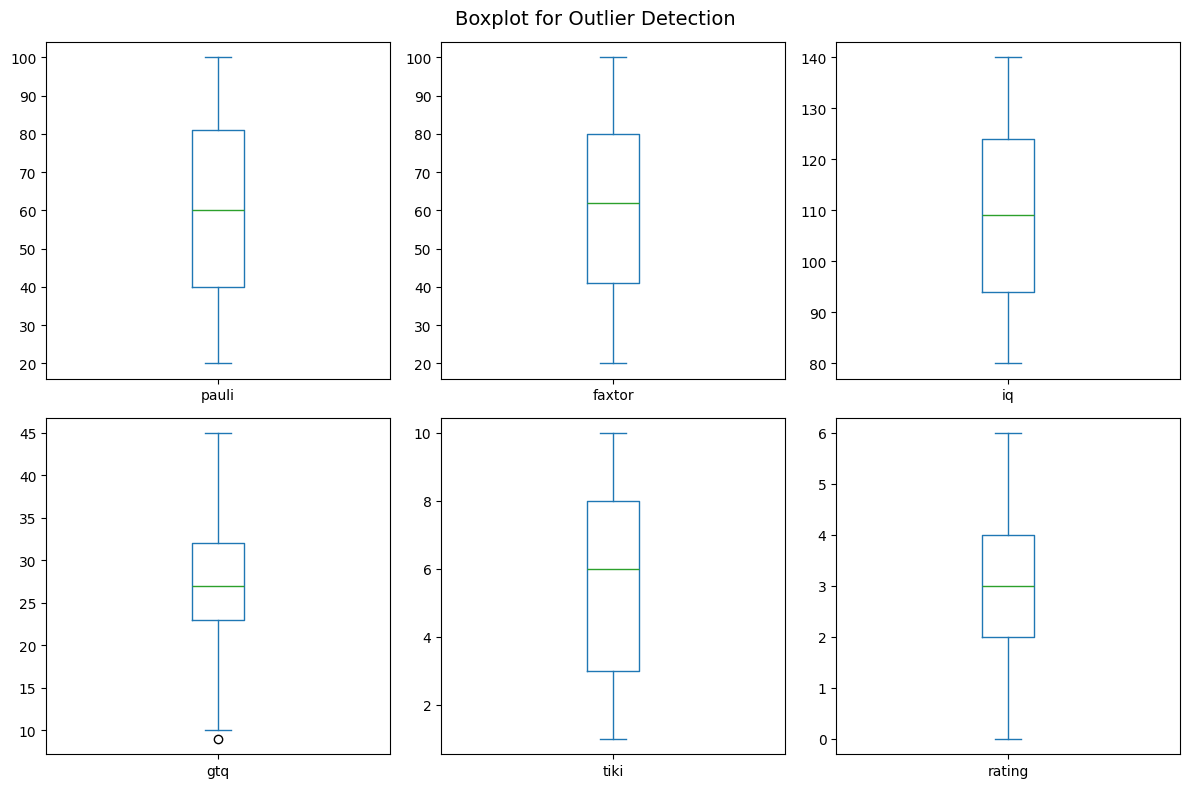


--- No outliers detected for pauli (IQR method) ---

--- No outliers detected for faxtor (IQR method) ---

--- No outliers detected for iq (IQR method) ---

--- Outlier values for gtq (IQR method) ---
[9.]

--- No outliers detected for tiki (IQR method) ---

--- No outliers detected for rating (IQR method) ---
--- Outlier values for rating (Logical method) ---
[6. 6. 0. 0.]

Outlier Detection Summary (IQR & Logical Ranges):


,Q1,Q3,IQR,Lower Bound (IQR),Upper Bound (IQR),Expected Min,Expected Max,Outlier Count (IQR),Outlier Count (Logical),Outlier % (IQR)
pauli,40.0,81.0,41.0,-21.5,142.5,20.0,100.0,0.0,0.0,0.0
faxtor,41.0,80.0,39.0,-17.5,138.5,20.0,100.0,0.0,0.0,0.0
iq,94.0,124.0,30.0,49.0,169.0,80.0,140.0,0.0,0.0,0.0
gtq,23.0,32.0,9.0,9.5,45.5,None,None,1,N/A,0.06
tiki,3.0,8.0,5.0,-4.5,15.5,1.0,10.0,0.0,0.0,0.0
rating,2.0,4.0,2.0,-1.0,7.0,1.0,5.0,0.0,4.0,0.0


In [27]:
# Select numeric columns to check for outliers
columns_to_check = ['pauli', 'faxtor', 'iq', 'gtq', 'tiki', 'rating']

# Create boxplots for visual inspection
df_main_outlier[columns_to_check].plot(
    kind='box',
    subplots=True,
    layout=(2, 3),
    figsize=(12, 8),
    sharex=False,
    sharey=False
)
plt.suptitle("Boxplot for Outlier Detection", fontsize=14)
plt.tight_layout()
plt.show()

# Define logical (expected) value ranges
# Note: 'gtq' is excluded because it represents a total score that varies widely
logical_ranges = {
    'pauli': (20, 100),
    'faxtor': (20, 100),
    'iq': (80, 140),
    'tiki': (1, 10),
    'rating': (1, 5)
}

# Dictionary to store outlier info summary
outlier_info = {}

# Loop through each numeric column
for col in columns_to_check:
    # --- Compute Interquartile Range (IQR) ---
    Q1 = df_main_outlier[col].quantile(0.25)
    Q3 = df_main_outlier[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # --- Detect outliers using IQR ---
    outliers_iqr = df_main_outlier[
        (df_main_outlier[col] < lower_bound) | (df_main_outlier[col] > upper_bound)
    ]
    
    # --- Detect logical (expected range) outliers ---
    if col in logical_ranges:  # skip gtq
        low_limit, high_limit = logical_ranges[col]
        outliers_logical = df_main_outlier[
            (df_main_outlier[col] < low_limit) | (df_main_outlier[col] > high_limit)
        ]
        logical_min = low_limit
        logical_max = high_limit
        logical_count = len(outliers_logical)
    else:
        logical_min = None
        logical_max = None
        logical_count = "N/A"
    
    # --- Print actual outlier values (IQR) ---
    if len(outliers_iqr) > 0:
        print(f"\n--- Outlier values for {col} (IQR method) ---")
        print(outliers_iqr[col].values)
    else:
        print(f"\n--- No outliers detected for {col} (IQR method) ---")

    # --- Print logical outlier values ---
    if col in logical_ranges and logical_count != "N/A" and logical_count > 0:
        print(f"--- Outlier values for {col} (Logical method) ---")
        print(outliers_logical[col].values)

    # --- Combine results into summary dict ---
    outlier_info[col] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'Lower Bound (IQR)': lower_bound,
        'Upper Bound (IQR)': upper_bound,
        'Expected Min': logical_min,
        'Expected Max': logical_max,
        'Outlier Count (IQR)': len(outliers_iqr),
        'Outlier Count (Logical)': logical_count,
        'Outlier % (IQR)': round((len(outliers_iqr) / len(df_main_outlier)) * 100, 2)
    }

# Create summary DataFrame
outlier_df = pd.DataFrame(outlier_info).T

# Display the summary table
print("\nOutlier Detection Summary (IQR & Logical Ranges):")
display(outlier_df)



  *   `gtq_total`: One value (9) was flagged as a statistical outlier by the IQR method (Lower Bound: 9.5). However, this value is not logically impossible given the potential range of GTQ scores.
       
   *    `rating`: Four values (two 0s, two 6s)  outside the expected logical range of 1-5. These are considered data errors.

* **Action Plan:**
    * The `gtq_total` outlier (9) will be **kept** as it's statistically low but plausibly valid.
    * The rows with `rating` values of 0 or 6 will be **removed** as they represent data errors and cannot be correctly classified for performance analysis.

In [28]:
# Remove logically invalid ratings
df_main_outlier = df_main_outlier[~df_main_outlier['rating'].isin([0,6])]

print(f"Removed rows with invalid ratings (0 or 6). Remaining data: {len(df_main_outlier)} rows.")


Removed rows with invalid ratings (0 or 6). Remaining data: 1790 rows.


##### Cleaned Data

After completing all data preprocessing steps — including handling missing values, logical validation, and outlier removal —  
the final cleaned dataset (`df_main_cleaned`) contains **1,790 valid and consistent records**.

In [29]:
#Make a copy to a clean data
df_main_cleaned = df_main_outlier.copy()

display(df_main_cleaned.head(), df_main_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1790 entries, 0 to 2009
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   employee_id              1790 non-null   object 
 1   fullname                 1790 non-null   object 
 2   nip                      1790 non-null   object 
 3   company_id               1790 non-null   int64  
 4   area_id                  1790 non-null   int64  
 5   position_id              1790 non-null   int64  
 6   department_id            1790 non-null   int64  
 7   division_id              1790 non-null   int64  
 8   directorate_id           1790 non-null   int64  
 9   grade_id                 1790 non-null   int64  
 10  education_id             1790 non-null   int64  
 11  major_id                 1790 non-null   int64  
 12  years_of_service_months  1790 non-null   int64  
 13  pauli                    1790 non-null   int64  
 14  faxtor                   1790

,employee_id,fullname,nip,company_id,area_id,position_id,department_id,division_id,directorate_id,grade_id,...,disc,disc_word,mbti,iq,gtq,tiki,rating,current_year,has_iq_data,has_gtq_data
0,EMP100000,Rendra Pratama,806137,1,4,1,6,3,3,2,...,SI,Steadiness-Influencer,ENFP,94.0,33.0,2,3.0,2025,1,1
1,EMP100001,Wulan Setiawan,476388,4,4,4,5,5,3,1,...,DS,Dominant-Steadiness,INTP,94.0,17.0,3,3.0,2025,1,1
2,EMP100002,Julia Jatmiko Situmorang,941921,1,3,5,1,1,3,1,...,DC,Dominant-Conscientious,ENFP,109.0,20.0,3,4.0,2025,1,1
3,EMP100003,Oka Halim,751615,1,3,4,2,1,1,2,...,SI,Steadiness-Influencer,ENTJ,85.0,39.0,3,3.0,2025,1,1
4,EMP100004,Dwi Pratama,443809,3,4,6,5,3,3,1,...,SC,Steadiness-Conscientious,INTJ,134.0,21.0,9,4.0,2025,1,1


None

### One to Many Data

#### Competencies data

In [30]:
df_competencies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20100 entries, 0 to 20099
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   employee_id   20100 non-null  object 
 1   pillar_code   20100 non-null  object 
 2   pillar_label  20100 non-null  object 
 3   score         18495 non-null  float64
 4   year          20100 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 785.3+ KB


##### Irrelevant Value check

In [31]:
# Make a copy for irrelevant value
df_competencies_irrelevant = df_competencies.copy()

In [32]:
# Check the irrelevant value for each columns mainly for pillar_code , pillar label , and score

print("Unique Pillar Code Counts")
print(df_competencies_irrelevant ['pillar_code'].value_counts())



Unique Pillar Code Counts
pillar_code
GDR    2010
CEX    2010
IDS    2010
QDD    2010
STO    2010
SEA    2010
VCU    2010
LIE    2010
FTC    2010
CSI    2010
Name: count, dtype: int64


In [33]:
print("Unique Pillar Label Counts")
print(df_competencies_irrelevant ['pillar_label'].value_counts())



Unique Pillar Label Counts
pillar_label
Growth Drive & Resilience       2010
Curiosity & Experimentation     2010
Insight & Decision Sharpness    2010
Quality Delivery Discipline     2010
Synergy & Team Orientation      2010
Social Empathy & Awareness      2010
Value Creation for Users        2010
Lead, Inspire & Empower         2010
Forward Thinking & Clarity      2010
Commercial Savvy & Impact       2010
Name: count, dtype: int64


In [34]:
print("\nScore Value Counts")
# Verify that only scores 1-5 (or imputed medians) exist
# Use sort_index() to see them in order
print(df_competencies_irrelevant ['score'].value_counts().sort_index())


Score Value Counts
score
0.0       26
1.0     2005
2.0     3799
3.0     5751
4.0     4640
5.0     2206
6.0       30
99.0      38
Name: count, dtype: int64


**Anomaly Detection in Competency Scores:**

The `.value_counts()` output for the `score` column confirms the presence of values outside the expected 1-5 range:
* Scores of **0.0** (26 instances)
* Scores of **6.0** (30 instances)
* Scores of **99.0** (38 instances)

These are considered data errors or invalid placeholders and must be handled before imputation.

**Action Plan:** These anomalous scores (0.0, 6.0, 99.0) will be replaced with `NaN` to treat them as missing values

In [35]:
# Clean Anomalous Scores (0, 6, 99) and Impute 

# Replace Anomalous Scores with NaN 
invalid_scores = [0.0, 6.0, 99.0]
original_nan_count = df_competencies_irrelevant['score'].isnull().sum() # Count NaNs before replacement

print(f"Original NaN count in score: {original_nan_count}")
print(f"Count of 0.0 scores: {(df_competencies_irrelevant['score'] == 0.0).sum()}")
print(f"Count of 6.0 scores: {(df_competencies_irrelevant['score'] == 6.0).sum()}") # Check for 6.0
print(f"Count of 99.0 scores: {(df_competencies_irrelevant['score'] == 99.0).sum()}")

# Replace 0, 6, and 99 with NaN
df_competencies_irrelevant['score'] = df_competencies_irrelevant['score'].replace(invalid_scores, np.nan)

new_nan_count = df_competencies_irrelevant['score'].isnull().sum()
print(f"\nValues 0.0, 6.0, and 99.0 replaced with NaN.")
print(f"New total NaN count in score: {new_nan_count}")

Original NaN count in score: 1605
Count of 0.0 scores: 26
Count of 6.0 scores: 30
Count of 99.0 scores: 38

Values 0.0, 6.0, and 99.0 replaced with NaN.
New total NaN count in score: 1699


##### Null Value 

In [36]:
# Make a copy for null value analysis
df_competencies_null = df_competencies_irrelevant.copy()
df_competencies_null.isnull().sum()

employee_id        0
pillar_code        0
pillar_label       0
score           1699
year               0
dtype: int64

There is **1699 missing values** specifically in the `score` column of the `df_competencies`  

 This represents a significant amount of missing data that needs to be addressed before comparative analysis.

In [37]:
#Check for the missing value per pillar
df_missing = (
    df_competencies_null.groupby("pillar_code")
    .apply(lambda g: pd.DataFrame({
        "missing_count": [g["score"].isna().sum()],
        "total": [len(g)],
        "missing_percentage": [g["score"].isna().sum() / len(g) * 100]
    }))
    .reset_index(level=1, drop=True)
    .reset_index()
    .sort_values("missing_percentage", ascending=False)
)

print(df_missing)


  pillar_code  missing_count  total  missing_percentage
8         STO            185   2010            9.203980
1         CSI            183   2010            9.104478
6         QDD            177   2010            8.805970
9         VCU            176   2010            8.756219
5         LIE            172   2010            8.557214
4         IDS            167   2010            8.308458
2         FTC            165   2010            8.208955
0         CEX            162   2010            8.059701
3         GDR            157   2010            7.810945
7         SEA            155   2010            7.711443


C:\Users\Fakhri\AppData\Local\Temp\ipykernel_8576\845659221.py:4: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.DataFrame({


Breaking down the missing scores **by competency pillar** shows that the missing data is distributed across **all pillars**, with percentages ranging from approximately **7.4% to 9.3%**. No single pillar has an exceptionally high rate of missingness compared to others.

**Implication:** Since the missingness is relatively low (<10%) but present everywhere, simply ignoring `NaN` (`skipna=True`) during group comparisons could still introduce bias if the missingness isn't random across performance groups. Therefore, imputation remains a practical approach to ensure consistent group comparisons across all pillars.

In [38]:
df_competencies_null[df_competencies_null['employee_id'] =="EMP100010"]

,employee_id,pillar_code,pillar_label,score,year
10,EMP100010,GDR,Growth Drive & Resilience,NaN,2025
2020,EMP100010,CEX,Curiosity & Experimentation,5.0,2025
4030,EMP100010,IDS,Insight & Decision Sharpness,5.0,2025
6040,EMP100010,QDD,Quality Delivery Discipline,5.0,2025
8050,EMP100010,STO,Synergy & Team Orientation,4.0,2025
10060,EMP100010,SEA,Social Empathy & Awareness,5.0,2025
12070,EMP100010,VCU,Value Creation for Users,NaN,2025
14080,EMP100010,LIE,"Lead, Inspire & Empower",4.0,2025
16090,EMP100010,FTC,Forward Thinking & Clarity,4.0,2025
18100,EMP100010,CSI,Commercial Savvy & Impact,5.0,2025


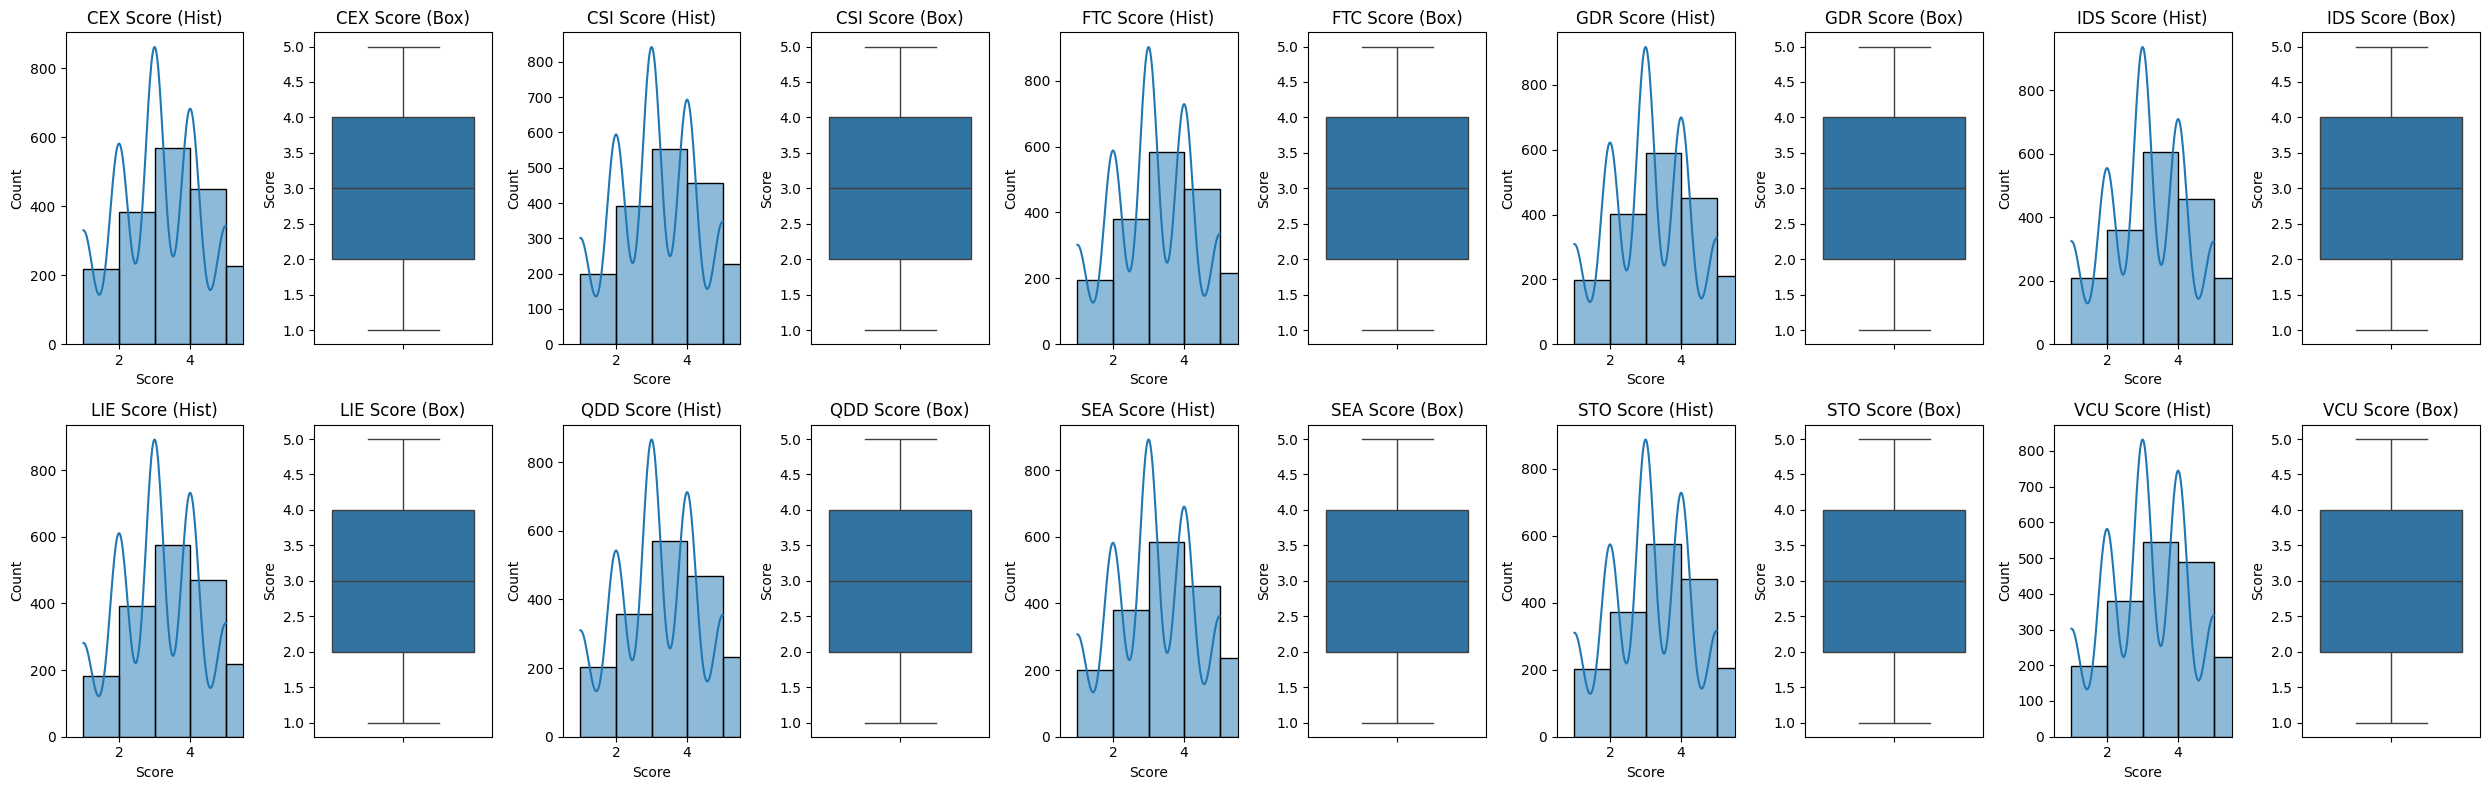

In [39]:
#Check Score Distribution per Competency Pillar (with X-axis Limit) ---

# Get unique pillar codes
pillar_codes = df_competencies_null['pillar_code'].unique()
n_pillars = len(pillar_codes)

# Determine grid size (e.g., 5 columns wide)
n_cols = 5
n_rows = (n_pillars + n_cols - 1) // n_cols # Calculate needed rows

# Create figure and axes grid
fig, axes = plt.subplots(n_rows, n_cols * 2, figsize=(n_cols * 5, n_rows * 4)) # 2 plots per pillar
axes = axes.flatten() # Flatten the axes array for easy iteration

plot_idx = 0
for i, pillar in enumerate(sorted(pillar_codes)): # Sort pillars for consistent order
    # Filter data for the current pillar, excluding NaNs for plotting distribution
    pillar_data = df_competencies_null[df_competencies_null['pillar_code'] == pillar]['score'].dropna()

    if not pillar_data.empty:
        # Histogram
        ax_hist = axes[plot_idx]
        sns.histplot(pillar_data, kde=True, ax=ax_hist, bins=range(1, 7)) # Optional: set bins for integer scores
        ax_hist.set_title(f'{pillar} Score (Hist)')
        ax_hist.set_xlabel('Score')
        # --- ADD THIS LINE ---
        ax_hist.set_xlim(0.5, 5.5) # Set x-axis limits from 0.5 to 5.5

        # Boxplot
        ax_box = axes[plot_idx + 1]
        sns.boxplot(y=pillar_data, ax=ax_box)
        ax_box.set_title(f'{pillar} Score (Box)')
        ax_box.set_ylabel('Score')
        # Optional: Set y-axis limit for boxplot too if needed
        # ax_box.set_ylim(0.5, 5.5)

        plot_idx += 2 # Move to the next pair of axes
    else:
         # Handle case where a pillar might have NO scores
        axes[plot_idx].set_title(f'{pillar} (No Data)')
        axes[plot_idx].set_visible(False)
        axes[plot_idx + 1].set_visible(False)
        plot_idx += 2


# Hide any unused subplots at the end
for j in range(plot_idx, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

* Given the slightly presence of outliers and potential skewness in the score distributions for various pillars, using the **pillar-specific median** is confirmed as the most **robust** imputation method. The median is less sensitive to extreme values compared to the mean, providing a more stable estimate of the central tendency for filling missing scores in this dataset.

In [40]:
# Impute Missing Competency Scores using Median *per Pillar

print(f"Missing 'score' in df_competencies (Before): {df_competencies_null['score'].isnull().sum()}")

# Calculate the median score FOR EACH pillar_code separately
# 'transform' calculates the median per group and then aligns it back to the original index
median_scores_by_pillar = df_competencies_null.groupby('pillar_code')['score'].transform('median')

# Fill NaN values in the 'score' column using the corresponding pillar's median
# Using the safer assignment method
df_competencies_null['score'] = df_competencies_null['score'].fillna(median_scores_by_pillar)

print(f"\nMissing 'score' in df_competencies imputed with pillar-specific median.")

print(f"Missing 'score' in df_competencies (After): {df_competencies_null['score'].isnull().sum()}") 

Missing 'score' in df_competencies (Before): 1699

Missing 'score' in df_competencies imputed with pillar-specific median.
Missing 'score' in df_competencies (After): 0


 The missing `score` values have been successfully imputed using the **median score specific to each `pillar_code`**. The verification step confirms that there are now **0 missing values** in the `score` column.

**Rationale:** While acknowledging that the original `NaN` might represent "not assessed" or "not applicable," this imputation method was chosen primarily to **enable consistent and fair comparison of average scores between performance groups across all competency pillars** during this exploratory phase. The potential bias introduced by using the median is noted and will be considered during interpretation, especially for pillars where the difference between groups is marginal.

##### Cleaned Competencies data

After handling anomalous scores (0.0, 6.0, 99.0) by converting them to `NaN` and subsequently imputing all missing values using the pillar-specific median, the final cleaned `df_competencies_cleaned` (filtered for year 2025) contains **20,100 records with complete and valid scores** within the expected 1-5 range (including imputed values).

In [41]:
#Cleaned data for competencies table
df_competencies_cleaned = df_competencies_null.copy()
df_competencies_cleaned

,employee_id,pillar_code,pillar_label,score,year
0,EMP100000,GDR,Growth Drive & Resilience,3.0,2025
1,EMP100001,GDR,Growth Drive & Resilience,2.0,2025
2,EMP100002,GDR,Growth Drive & Resilience,3.0,2025
3,EMP100003,GDR,Growth Drive & Resilience,4.0,2025
4,EMP100004,GDR,Growth Drive & Resilience,4.0,2025
...,...,...,...,...,...
20095,DUP1942,CSI,Commercial Savvy & Impact,5.0,2025
20096,DUP2096,CSI,Commercial Savvy & Impact,3.0,2025
20097,DUP4177,CSI,Commercial Savvy & Impact,2.0,2025
20098,DUP9801,CSI,Commercial Savvy & Impact,5.0,2025
